In [ ]:
#%% Import libraries and load data

import os
import medmnist
from medmnist import INFO
from torchvision.transforms import ToPILImage, Grayscale, ToTensor
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Grayscale, Normalize
import deeptrack as dt
import torch
import deeplay as dl
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from matplotlib.patches import Rectangle
from torchvision import transforms
from torch.utils import data

data_flag = 'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define grayscale transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
])

labeled_dataset = DataClass(split='train', transform=transform, download=True)
train_dataset = list(map(lambda x: (x[0], x[0]), labeled_dataset)) #Pair image and target
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)

labeled_test_dataset = DataClass(split='test', transform=transform, download=True)
#test_dataset = list(map(lambda x: (x[0], x[0]), labeled_test_dataset))
test_loader = data.DataLoader(labeled_test_dataset, batch_size=64, shuffle=False)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


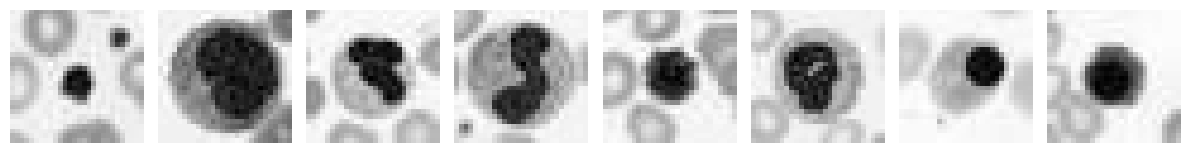

In [ ]:
#%%

def show_samples(dataset, n=8):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        img_tensor, _ = dataset[i]
        img = img_tensor.squeeze().numpy()  
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

In [ ]:
# %%

vae = dl.VariationalAutoEncoder(
    latent_dim=2, channels=[16,16],
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"), beta=1,
).create()

print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=784, out_features=2, bias=True)
  (fc_var): Linear(in_features=784, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=784, bias=True)
  (decoder): ConvolutionalDecoder2d(
    (block

In [ ]:
#%%

vae_trainer = dl.Trainer(max_epochs=10, accelerator="auto")
vae_trainer.fit(vae, train_loader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 4.8 K  | train
1 | fc_mu               | Linear                 | 1.6 K  | train
2 | fc_var              | Linear                 | 1.6 K  | train
3 | fc_dec              | Linear                 | 2.4 K  | train
4 | decoder             | ConvolutionalDecoder2d | 6.9 K  | train
5 | reconstruction_loss | BCELoss                | 0      | train
6 | train_metrics       | MetricCollection       | 0      | train
7 | val_metrics         | MetricCollection       | 0      | train
8 | test_metrics        | MetricCollection       | 0      | train
9 | optimizer           | Adam                   |

Training: |          | 0/? [00:00<?, ?it/s]

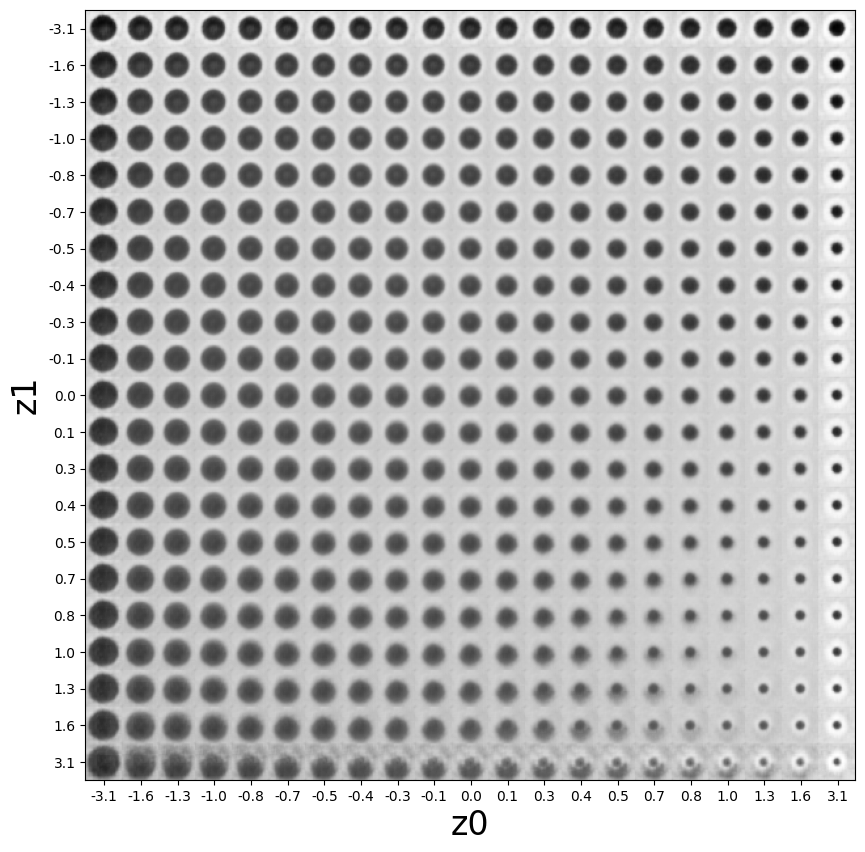

In [ ]:
#%%

img_num, img_size = 21, 28
z0_grid = z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
      z = torch.stack((z0, z1)).unsqueeze(0)
      generated_image = vae.decode(z).clone().detach()
      image[i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size] = \
          generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xlabel("z0", fontsize=24)
plt.xticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z0_grid.numpy(), 1))
plt.ylabel("z1", fontsize=24)
plt.yticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z1_grid.numpy(), 1))
plt.show()

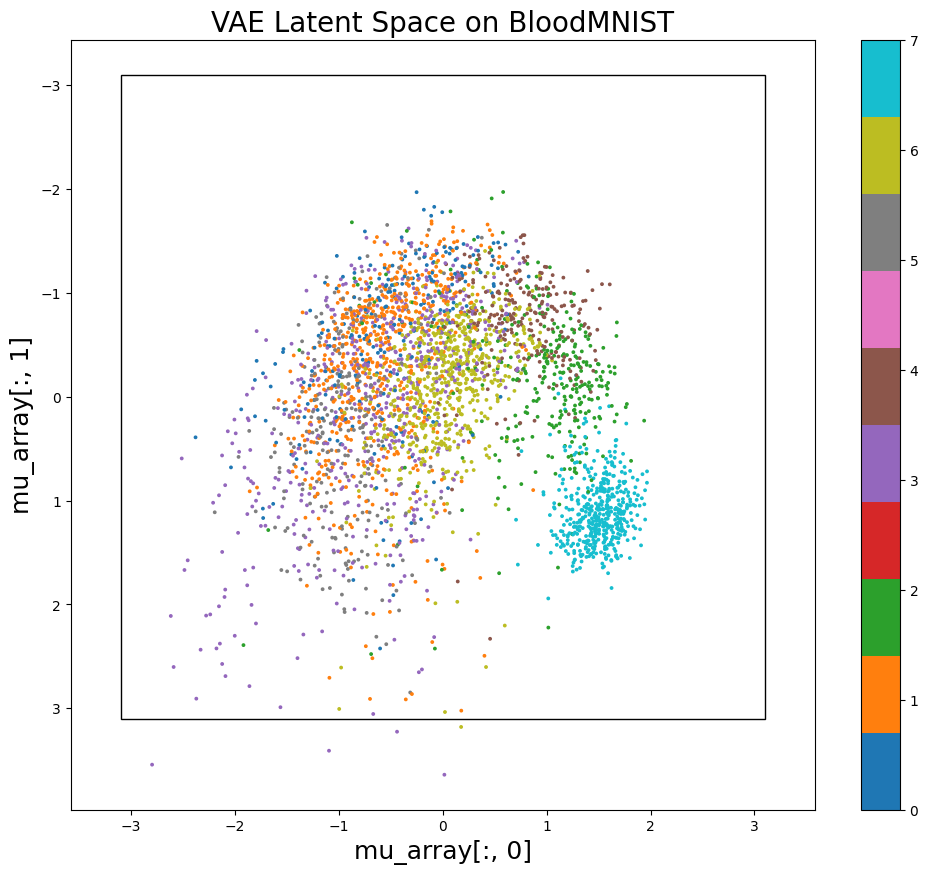

In [ ]:
#%%

mu_list, test_labels = [], []
vae.eval()
with torch.no_grad():
    for image, label in test_loader:
        mu, _ = vae.encode(image)
        mu_list.append(mu)
        test_labels.append(label)

mu_array = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

# 8. Plot latent space
plt.figure(figsize=(12, 10))
plt.scatter(mu_array[:, 0], mu_array[:, 1], s=3, c=test_labels, cmap="tab10")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.xlabel("mu_array[:, 0]", fontsize=18)
plt.ylabel("mu_array[:, 1]", fontsize=18)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.colorbar()
plt.title("VAE Latent Space on BloodMNIST", fontsize=20)
plt.show()